## Trabajo práctico integrador 

Se importan las librerías importantes que se van a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix

In [3]:
# Si es GPU esta disponible que lo use sino que use el CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [4]:
# Descargamos las bases de datos de Fashion MNIST que se van a utilizar para entrenar, validar y testear la red
train_dataset_all = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
#Se separa el conjunto de entrenamiento en entrenamiento y validación. 
train, valid = random_split(train_dataset_all,[50000,10000])

In [6]:
# Se cargan los datos
train_loader = DataLoader(train, batch_size=100, shuffle =  True)
valid_loader = DataLoader(valid, batch_size=100, shuffle =  True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle = True)

In [7]:
# Dimensiones de los tensores
batch = next(iter(train_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([100, 1, 28, 28]) torch.Size([100])


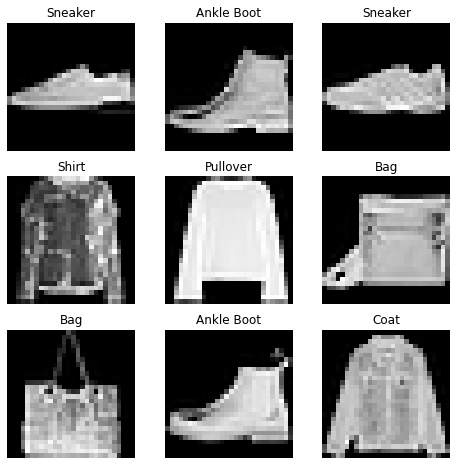

In [8]:
# Etiquetas de las imágenes y una muestra de las mismas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset_all), size=(1,)).item()
    img, label = train_dataset_all[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.savefig('fashion-mnist.pdf')
plt.show()

In [24]:
# Arquitectura de la red convolucional
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.30)
        self.fc2 = nn.Linear(in_features=600, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=10)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.soft(out)
        
        return out


In [25]:
FCNN = FashionCNN()
FCNN.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(FCNN.parameters(), lr=learning_rate)
print(FCNN)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=600, bias=True)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=600, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (soft): Softmax(dim=1)
)


## Funciones de entrenamiento y validación

In [26]:
def training(dataloader, model):
    train = 0.0
    model.train() 
    for batch, (image,label) in enumerate(dataloader): 
        image = image.to(device)
        label = label.to(device)
        
        pred = model(image)
    
        loss = loss_fn(pred,label)
    
        optimizer.zero_grad()
    
        loss.backward()
    
        optimizer.step()
    
        train += loss.item()
        
    train /= len(dataloader)
    
    return train

def validate(dataloader, model):
    model.eval() 
    valid = 0.0
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            
            target = model(image)
        
            loss = loss_fn(target,label)
            
            valid += loss.item() 
            
            predictions = torch.max(target, 1)[1].to(device)
            
            correct += (predictions == label).sum()
            
            total += len(label)
            
    valid /= len(dataloader)
    
    accuracy = correct*100/total
    
    return valid, accuracy

In [ ]:
epochs = 10
train_loss = []
valid_loss = []
valid_accu = []

for e in range(1, epochs+1):
    training_loss = training(train_loader, FCNN)
    validation_loss, validation_accu = validate(valid_loader, FCNN)
    print(f'Epoch {e}/{epochs}, Train Loss: {training_loss}, Valid Loss: {validation_loss}, Valid Accuracy: {validation_accu}')
    train_loss.append(training_loss)
    valid_loss.append(validation_loss)
    valid_accu.append(validation_accu)

Epoch 1/10, Train Loss: 1.9600207023620606, Valid Loss: 1.927087540626526, Valid Accuracy: 53.369998931884766
Epoch 2/10, Train Loss: 1.9758291890621185, Valid Loss: 1.915426584482193, Valid Accuracy: 54.56999969482422
Epoch 3/10, Train Loss: 1.917182055234909, Valid Loss: 1.911983038187027, Valid Accuracy: 54.91999816894531
Epoch 4/10, Train Loss: 1.914458379983902, Valid Loss: 1.9133020520210267, Valid Accuracy: 54.779998779296875


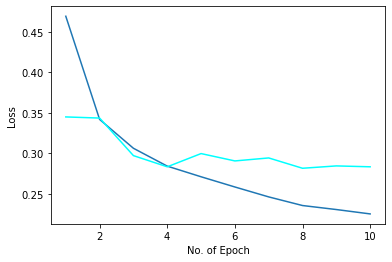

In [13]:
# Gráfico de la función de pérdida de entrenamiento y la función de pérdida de validación
plt.plot([i for i in range(1, 11)],train_loss)
plt.plot([i for i in range(1, 11)],valid_loss, c ='cyan')
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.savefig('train_valid_loss_conv.pdf')
plt.show()

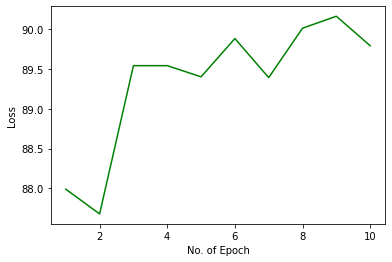

In [14]:
# Gráfico de la función de precisión del modelo sobre el conjunto de validación 
plt.plot([i for i in range(1, 11)],valid_accu, c = 'green')
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.savefig('valid_accu_conv.pdf')
plt.show()

### Precisión del modelo sobre cada una de las etiquetas de la base de datos 

In [15]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]
labels_list = []
prediction_list = []
with torch.no_grad():
    for images, labels in test_loader: #Esta vez se prueba la precisión del modelo sobre el conjunto de testeo
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        
        test = images
        outputs = FCNN(test)
        predicted = torch.max(outputs, 1)[1] #Para obtener el número de etiqueta que predijo se utiliza torch.max 
        prediction_list.append(predicted)
        c = (predicted == labels).squeeze() #Vemos si es igual al label, es decir, si la predicción es correcta
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
 #Vemos que tan bien predijo cada etiqueta           
label_list = list(labels_map.values()) #Transforma el diccionario en una lista    
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(label_list[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-Shirt: 78.60%
Accuracy of Trouser: 98.30%
Accuracy of Pullover: 78.80%
Accuracy of Dress: 87.80%
Accuracy of Coat: 87.70%
Accuracy of Sandal: 98.20%
Accuracy of Shirt: 78.80%
Accuracy of Sneaker: 96.10%
Accuracy of Bag: 96.80%
Accuracy of Ankle Boot: 96.70%


In [16]:
# Se necesitan algunas transformaciones de los tensores a listas para poder hacer el classification report
from itertools import chain 

prediction_l = [prediction_list[i].tolist() for i in range(len(prediction_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
prediction_l = list(chain.from_iterable(prediction_l))
labels_l = list(chain.from_iterable(labels_l))

In [51]:
import sklearn.metrics as metrics
import dataframe_image as dfi

df = pd.DataFrame(metrics.classification_report(labels_l, prediction_l, output_dict=True)).T
df

,precision,recall,f1-score,support
0,0.886133,0.7860,0.833068,1000.0000
1,0.983984,0.9830,0.983492,1000.0000
2,0.882419,0.7880,0.832541,1000.0000
3,0.919372,0.8780,0.898210,1000.0000
4,0.821161,0.8770,0.848162,1000.0000
5,0.983968,0.9820,0.982983,1000.0000
6,0.649629,0.7880,0.712155,1000.0000
7,0.954320,0.9610,0.957648,1000.0000
8,0.985743,0.9680,0.976791,1000.0000
9,0.968938,0.9670,0.967968,1000.0000


In [18]:
# Red neuronal sin capa de convolución y con una sola capa intermedia donde n es el tamaño de la misma. 
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(28*28,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,10)
        
    def forward(self,x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return x

In [19]:
n = 256
NN = NeuralNet()
NN.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
print(NN)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
)


In [20]:
# Se entrena y se valida el modelo 
epochs = 20
train_loss_net = []
valid_loss_net = []
valid_accu_net = []

for e in range(1, epochs+1):
    training_loss = training(train_loader, NN)
    validation_loss, validation_accu = validate(valid_loader, NN)
    print(f'Epoch {e}/{epochs}, Train Loss: {training_loss}, Valid Loss: {validation_loss}, Valid Accuracy: {validation_accu}')
    train_loss_net.append(training_loss)
    valid_loss_net.append(validation_loss)
    valid_accu_net.append(validation_accu)

Epoch 1/20, Train Loss: 0.582552061855793, Valid Loss: 0.4203771914541721, Valid Accuracy: 84.47000122070312
Epoch 2/20, Train Loss: 0.40926739114522936, Valid Loss: 0.37364692643284797, Valid Accuracy: 86.0
Epoch 3/20, Train Loss: 0.37169280159473417, Valid Loss: 0.3467188407480717, Valid Accuracy: 87.41000366210938
Epoch 4/20, Train Loss: 0.3504994460642338, Valid Loss: 0.33191036209464075, Valid Accuracy: 87.91000366210938
Epoch 5/20, Train Loss: 0.33088768446445466, Valid Loss: 0.3199242749810219, Valid Accuracy: 88.66999816894531
Epoch 6/20, Train Loss: 0.32177480483055115, Valid Loss: 0.33812385305762294, Valid Accuracy: 87.44999694824219
Epoch 7/20, Train Loss: 0.3095157310366631, Valid Loss: 0.30492294698953626, Valid Accuracy: 88.77999877929688
Epoch 8/20, Train Loss: 0.29674978721141815, Valid Loss: 0.30628640949726105, Valid Accuracy: 88.69000244140625
Epoch 9/20, Train Loss: 0.28962839011847974, Valid Loss: 0.30241987347602844, Valid Accuracy: 89.0199966430664
Epoch 10/20, 

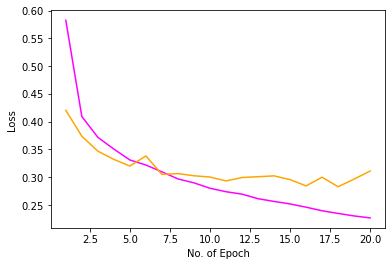

In [21]:
# Gráfico sobre la función de pérdida del entrenamiento y de la validación
plt.plot([i for i in range(1, 21)],train_loss_net, c = 'magenta')
plt.plot([i for i in range(1, 21)],valid_loss_net, c ='orange')
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.savefig('train_valid_loss.pdf')
plt.show()

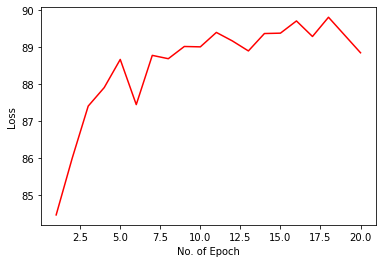

In [22]:
# Gráfico sobre la precisión del modelo sobre el conjunto de validación 
plt.plot([i for i in range(1, 21)],valid_accu_net, c = 'red')
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.savefig('valid_accu.pdf')
plt.show()

### Precisión del modelo sobre cada una de las etiquetas de la base de datos 

In [23]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]
labels_list_2 = []
prediction_list_2 = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list_2.append(labels)
        test = images
        out = NN(test)
        predict = torch.max(out, 1)[1]
        prediction_list_2.append(predict)
        c = (predict == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
            
label_list = list(labels_map.values()) #Transforma el diccionario en una lista    
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(label_list[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-Shirt: 84.80%
Accuracy of Trouser: 96.80%
Accuracy of Pullover: 83.50%
Accuracy of Dress: 91.10%
Accuracy of Coat: 87.00%
Accuracy of Sandal: 94.00%
Accuracy of Shirt: 55.90%
Accuracy of Sneaker: 93.70%
Accuracy of Bag: 95.20%
Accuracy of Ankle Boot: 97.90%


In [24]:
from itertools import chain 

prediction_l_2 = [prediction_list_2[i].tolist() for i in range(len(prediction_list_2))]
labels_l_2 = [labels_list_2[i].tolist() for i in range(len(labels_list_2))]
prediction_l_2 = list(chain.from_iterable(prediction_l_2))
labels_l_2 = list(chain.from_iterable(labels_l_2))

In [35]:
import sklearn.metrics as metrics

df2 = pd.DataFrame(metrics.classification_report(labels_l_2, prediction_l_2, output_dict=True)).T
df2

,precision,recall,f1-score,support
0,0.824101,0.8480,0.835880,1000.0000
1,0.990788,0.9680,0.979262,1000.0000
2,0.735035,0.8350,0.781835,1000.0000
3,0.875120,0.9110,0.892700,1000.0000
4,0.754553,0.8700,0.808175,1000.0000
5,0.986359,0.9400,0.962622,1000.0000
6,0.808973,0.5590,0.661147,1000.0000
7,0.957099,0.9370,0.946943,1000.0000
8,0.983471,0.9520,0.967480,1000.0000
9,0.912395,0.9790,0.944525,1000.0000
